# Reactor Kinetics Example 

Jialu Wang (jwang44@nd.edu) and Alex Dowling (adowling@nd.edu)

University of Notre Dame

This notebook conducts design of experiments for a reactor kinetics experiment with the Pyomo.DOE.
    

In [1]:
import matplotlib.pyplot as plt
from pyomo.environ import *
from pyomo.dae import *

import numpy as np
from scipy.interpolate import interp2d
import pandas as pd 
from itertools import permutations, product, combinations

from fim_doe import *
from pyomo.contrib.sensitivity_toolbox.sens import sipopt

## Define Reaction Example Mathematical Model

Consider two chemical reactions that converts molecule $A$ to desired product $B$ and a less valuable side-product $C$.

$A \overset{k_1}{\rightarrow} B \overset{k_2}{\rightarrow} C$

Our ultimate goals is to design a large-scale continous reactor that maximizes the production of $B$. This general sequential reactions problem is widely applicable to CO$_2$ capture and industry more broadly (petrochemicals, pharmasuticals, etc.).

The rate laws for these two chemical reactions are:

$r_A = -k_1 C_A$

$r_B = k_1 C_A - k_2 C_B$

$r_C = k_2 C_B$

Here, $C_A$, $C_B$, and $C_C$ are the concentrations of each species. The rate constants $k_1$ and $k_2$ depend on temperature as follows:

$k_1 = A_1 \exp{\frac{-E_1}{R T}}$

$k_2 = A_2 \exp{\frac{-E_2}{R T}}$

$A_1, A_2, E_1$, and $E_2$ are fitted model parameters. $R$ is the ideal-gas constant and $T$ is absolute temperature.

Using the **CCSI$^2$ toolset**, we would like do the following perform:

Perform **uncertainty quantification** and **design of experiments** on a small-scale **batch reactor** to infer parameters $A_1$, $A_2$, $E_1$, and $E_2$.

### Batch reactor

The concenrations in a batch reactor evolve with time per the following differential equations:

$$ \frac{d C_A}{dt} = r_A = -k_1 C_A $$

$$ \frac{d C_B}{dt} = r_B = k_1 C_A - k_2 C_B $$

$$ \frac{d C_C}{dt} = r_C = k_2 C_B $$

This is a linear system of differential equations. Assuming the feed is only species $A$, i.e., 

$$C_A(t=0) = C_{A0} \quad C_B(t=0) = 0 \quad C_C(t=0) = 0$$

When the temperature is constant, it leads to the following analytic solution:

$$C_A(t) = C_{A,0} \exp(-k_1 t)$$

$$C_B(t) = \frac{k_1}{k_2 - k_1} C_{A,0} \left[\exp(-k_1 t) - \exp(-k_2 t) \right]$$

$$C_C(t) = C_{A,0} - \frac{k_2}{k_2 - k_1} C_{A,0} \exp(-k_1 t) + \frac{k_1}{k_2 - k_1} \exp(-k_2 t) C_{A,0} = C_{A,0} - C_{A}(t) - C_{B}(t)$$

In [2]:
from reactor_models import *

Three versions of this model is accomplished: 

Dynamic-DAE model: Temperature varying model discretized and integrated by Pyomo.DAE

Constant-DAE model: Temperature constant model discretized and integrated by Pyomo.DAE

Constant-analytical model: Temperature constant model discretized manually and using the analytical expressions for state variables.

In [3]:
# choose model from 'dynamic-DAE', 'constant-DAE', 'constant-analytical'
#model_opt = 'dynamic-DAE'
model_opt = 'constant-DAE'
#model_opt = 'constant-analytical'

if (model_opt=='dynamic-DAE'):
    createmod = create_model_dae
    disc = discretizer
    t_control = [0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1]
    
elif (model_opt=='constant-DAE'):
    createmod = create_model_dae_const
    disc = discretizer
    t_control = [0]
    
elif (model_opt=='constant-analytical'):
    createmod = create_model_alge
    disc = None
    t_control = [0]

    
# design variable and its control time set
dv_pass = {'CA0': [0],'T': t_control}
    
# Define measurement time points
t_measure = [0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1]

In [4]:
# Define parameter nominal value 
parameter_dict = {'A1': 84.79085853498033, 'A2': 371.71773413976416, 'E1': 7.777032028026428, 'E2': 15.047135137500822}

def generate_exp(t_set, CA0, T):  
    '''Generate experiments. 
    t_set: time control set for T.
    CA0: CA0 value
    T: A list of T 
    '''
    assert(len(t_set)==len(T)), 'T should have the same length as t_set'
    
    T_con_initial = {}
    for t, tim in enumerate(t_set):
        T_con_initial[tim] = T[t]
        
    dv_dict_overall = {'CA0': {0: CA0},'T': T_con_initial}
    return dv_dict_overall

In [13]:
# empty prior
#prior_all = np.zeros((4,4))


# add prior information
prior_5_300 = pd.read_csv('fim_5_300_scale.csv')
prior_5_300_500 = pd.read_csv('fim_5_300_500_scale.csv')

prior_all = prior_5_300_500


prior_pass=np.asarray(prior_all)

#L_initials = np.linalg.cholesky(prior_pass)
#print(L_initials)

print('The prior information FIM:', prior_pass)
print('Prior Det:', np.linalg.det(prior_pass))
print('Eigenvalue of the prior experiments FIM:', np.linalg.eigvals(prior_pass))
print('Eigenvalue of the prior experiments FIM:', np.linalg.eigh(prior_pass)[1])

The prior information FIM: [[  28.67892806    5.41249739  -81.73674601  -24.02377324]
 [   5.41249739   26.40935036  -12.41816477 -139.23992532]
 [ -81.73674601  -12.41816477  240.46276004   58.76422806]
 [ -24.02377324 -139.23992532   58.76422806  767.25584508]]
Prior Det: 140189.67370995492
Eigenvalue of the prior experiments FIM: [8.00463185e+02 2.60471503e+02 4.84545259e-01 1.38765050e+00]
Eigenvalue of the prior experiments FIM: [[-0.77629273 -0.54211788  0.31871243 -0.0435912 ]
 [ 0.56614148 -0.80478003 -0.01425817 -0.177791  ]
 [-0.25919275 -0.19059651 -0.94009108  0.11278677]
 [ 0.09834911 -0.14869526  0.12019924  0.97661114]]


## Compute FIM 

This method computes an MBDoE optimization problem with no Degree of Freedom.

In [14]:
# choose from 'simultaneous', 'sequential', 'sipopt'
#sensi_opt = 'simultaneous_finite'
sensi_opt = 'sequential_finite'
#sensi_opt = 'sequential_sipopt'
#sensi_opt = 'sequential_kaug'

# Define experiments
if (model_opt=='dynamic-DAE'):
    exp1 = generate_exp(t_control, 5, [570.21, 300, 300, 300, 300, 300, 300, 300, 300])
else: 
    exp1 = generate_exp(t_control, 5, [500])

print('Design variable:', exp1)

Design variable: {'CA0': {0: 5}, 'T': {0: 500}}


In [15]:
doe_object = DesignOfExperiments(parameter_dict, dv_pass,
                                 ['CA','CB','CC'], t_measure, createmod,
                                prior_FIM=prior_pass, discretize_model=disc)


if_s = True
result = doe_object.compute_FIM(exp1,mode=sensi_opt, FIM_store_name = 'dynamic.csv', scale_nominal_param_value=if_s, formula='central')


if sensi_opt == 'simultaneous_finite':
    result.extract_FIM(doe_object.m, doe_object.design_timeset,
                                                          doe_object.square_result, doe_object.obj_opt)
else: 
    result.calculate_FIM(doe_object.jac, doe_object.design_values)

Sensitivity information is scaled by its corresponding parameter nominal value.
Ipopt 3.13.3: linear_solver=ma57
halt_on_ampl_error=yes


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.13.3, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:     2979
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      289

Total number of variables............................:      869
                     variables with only lower bounds:      289
                variables with lower and upper bounds:       96
                     variab

Ipopt 3.13.3: linear_solver=ma57
halt_on_ampl_error=yes


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.13.3, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:     2979
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      289

Total number of variables............................:      869
                     variables with only lower bounds:      289
                variables with lower and upper bounds:       96
                     variables with only upper bounds:        0
Total number of equality constraints.......

Ipopt 3.13.3: linear_solver=ma57
halt_on_ampl_error=yes


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.13.3, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:     2979
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      289

Total number of variables............................:      869
                     variables with only lower bounds:      289
                variables with lower and upper bounds:       96
                     variables with only upper bounds:        0
Total number of equality constraints.......

Ipopt 3.13.3: linear_solver=ma57
halt_on_ampl_error=yes


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.13.3, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:     2979
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      289

Total number of variables............................:      869
                     variables with only lower bounds:      289
                variables with lower and upper bounds:       96
                     variables with only upper bounds:        0
Total number of equality constraints.......

This run takes wall clock time:  1.4369690418243408  s.
Existed information has been added.
FIM: [[  34.82920486    8.98505797  -93.24108544  -36.95313311]
 [   8.98505797   34.72118757  -19.10100722 -169.32073026]
 [ -93.24108544  -19.10100722  261.98208841   82.94992731]
 [ -36.95313311 -169.32073026   82.94992731  876.11924893]]
Trace: 1207.6517297594096
Determinant: 561034.454057873
Condition number: 1016.4074033638327
Minimal eigen value: 0.9078292004202301
Eigen values: [9.22724320e+02 2.81641554e+02 9.07829200e-01 2.37802648e+00]
Eigen vectors: [[ 0.05653415 -0.32984125 -0.77053642  0.54247789]
 [ 0.1886356   0.01601807  0.56991922  0.79959497]
 [-0.13533499  0.93253119 -0.2662067   0.20298772]
 [-0.97103292 -0.14606077  0.10295482  0.15862413]]


In [16]:
print('======Result summary======')
print('Four design criteria log10() value:')
print('A-optimality:', np.log10(result.trace))
print('D-optimality:', np.log10(result.det))
print('E-optimality:', np.log10(result.min_eig))
print('Modified E-optimality:', np.log10(result.cond))

======Result summary======
Four design criteria log10() value:
A-optimality: 3.081941707752758
D-optimality: 5.748989532820771
E-optimality: -0.04199585224152744
Modified E-optimality: 3.0070678197277516


### Run sequential DOE automatically

This method runs a series of experiments in a row.

In [ ]:
# this only works for constant T mode. 
exp1 = generate_exp(t_control, 5, [300])
exp2 = generate_exp(t_control, 5, [500.92])
exp3 = generate_exp(t_control, 5, [528])
exp4 = generate_exp(t_control, 5, [546.8])
exp5 = generate_exp(t_control, 5, [562])

In [ ]:

exp_all = [exp1, exp2, exp3, exp4, exp5]


doe_object = DesignOfExperiments(parameter_dict, dv_pass,
                                 ['CA','CB','CC'], t_measure, createmod,
                                prior_FIM=prior_pass, discretize_model=disc)

# choose from 'simultaneous', 'sequential', 'sipopt'
#sensi_opt = 'simultaneous_finite'
sensi_opt = 'sequential_finite'
#sensi_opt = 'sequential_sipopt'
if_s = True
result = doe_object.sequential_exp(exp_all, mode=sensi_opt, tee_option=True,
                                    scale_nominal_param_value=if_s, formula='central')

In [ ]:
print('=======Result summary=======')
for i in range(len(exp_all)):
    print('The ', i+1,'th experiment has optimality log10() values:')
    print('A-optimality:', np.log10(result[0][i].trace))
    print('D-optimality:', np.log10(result[0][i].det))
    print('E-optimality:', np.log10(result[0][i].min_eig))
    print('Modified E-optimality:', np.log10(result[0][i].cond))

## Optimization

In [17]:
doe_object = DesignOfExperiments(parameter_dict, dv_pass, 
                                 ['CA','CB','CC'], t_measure, createmod,
                                 prior_FIM=prior_pass, discretize_model=disc)

square_result, optimize_result = doe_object.optimize_doe(exp1, if_optimize=True, if_Cholesky=True, scale_nominal_param_value=True, objective_option='trace', L_initial=None)


Sensitivity information is scaled by its corresponding parameter nominal value.
Ipopt 3.13.3: linear_solver=ma57
halt_on_ampl_error=yes


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.13.3, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:    24280
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1930

Total number of variables............................:     6414
                     variables with only lower bounds:     2316
                variables with lower and upper bounds:       96
                     variab

 184r-1.1291428e+01 2.33e+03 1.18e+03   0.9 6.55e-01   3.3 1.00e+00 1.00e+00f  1
 185r-1.1336775e+01 2.33e+03 1.55e+03   0.9 1.96e+00   2.8 1.00e+00 1.00e+00f  1
 186r-1.1351554e+01 2.33e+03 1.17e+03   0.9 7.37e-01   3.2 1.00e+00 1.00e+00f  1
 187r-1.1395199e+01 2.33e+03 1.31e+03   0.9 2.21e+00   2.7 1.00e+00 1.00e+00f  1
 188r-1.1409545e+01 2.33e+03 1.17e+03   0.9 8.28e-01   3.2 1.00e+00 1.00e+00f  1
 189r-1.1454604e+01 2.33e+03 1.60e+03   0.9 2.48e+00   2.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 190r-1.1469483e+01 2.33e+03 1.17e+03   0.9 9.31e-01   3.1 1.00e+00 1.00e+00f  1
 191r-1.1506626e+01 2.32e+03 1.17e+03   0.9 2.79e+00   2.6 1.00e+00 7.69e-01f  1
 192r-1.1570982e+01 2.32e+03 2.29e+03   0.9 8.34e+00   2.1 6.19e-01 4.59e-01f  1
 193r-1.1612090e+01 2.32e+03 1.17e+03   0.9 3.13e+00   2.6 1.00e+00 8.17e-01f  1
 194r-1.1623273e+01 2.32e+03 1.17e+03   0.9 9.26e+00   2.1 9.94e-01 4.77e-02f  1
 195r-1.2061835e+01 2.32e+03

FIM: [[  34.82843309    8.984655    -93.24076113  -36.95321436]
 [   8.984655     34.72022839  -19.10068151 -169.3211828 ]
 [ -93.24076113  -19.10068151  261.9835756    82.95162856]
 [ -36.95321436 -169.3211828    82.95162856  876.13508114]]
Trace: 1207.6673182276875
Determinant: 560761.169565876
Condition number: 1016.6953775260088
Minimal eigen value: 0.9075873179593128
Eigen values: [9.22739831e+02 2.81642446e+02 9.07587318e-01 2.37745409e+00]
Eigen vectors: [[ 0.056533   -0.32983839 -0.77051818  0.54250567]
 [ 0.18863263  0.01601912  0.56994713  0.79957575]
 [-0.13533434  0.93253239 -0.26619814  0.20299388]
 [-0.97103366 -0.14605949  0.10295902  0.15861809]]
Model objective: 13.237050371369904
Objective(trace) is: 560761.1696834561
Solution of  CA0  : [5]
Solution of  T  : [500]
======problem solver output======
converged
Ipopt 3.13.3: linear_solver=ma57
halt_on_ampl_error=yes


******************************************************************************
This program contains Ipo

In [18]:
print('======Result summary======')
print('This optimization is solved with status:', optimize_result.status)
print('It gives solution:', optimize_result.solution)
print('The log10(OF) optimized is:', optimize_result.obj_value)
print('The result FIM is:', optimize_result.FIM)

======Result summary======
This optimization is solved with status: converged
It gives solution: {'CA0': [5.0], 'T': [300.0000242851759]}
The log10(OF) optimized is: 13.237846622082674
The result FIM is: [[  51.20654061    7.25310602 -151.97486781  -35.12719512]
 [   7.25310602   44.50764054  -18.15692555 -248.41790943]
 [-151.97486781  -18.15692555  459.45595083   93.38314749]
 [ -35.12719512 -248.41790943   93.38314749 1425.87232729]]


## Grid search for 2 design variables

In [19]:
design_ranges = [list(np.linspace(1,5,9)), list(np.linspace(300,700,9))]

dv_apply_name = ['CA0','T']

dv_apply_time = [[0],t_control]

# Define experiments
if (model_opt=='dynamic-DAE'):
    exp1 = generate_exp(t_control, 5, [570.21, 300, 300, 300, 300, 300, 300, 300, 300])
else: 
    exp1 = generate_exp(t_control, 5, [500])

In [20]:
doe_object = DesignOfExperiments(parameter_dict, dv_pass, 
                                 ['CA','CB','CC'], t_measure, createmod,
                                 prior_FIM=prior_pass, discretize_model=disc)

all_fim = doe_object.run_grid_search(exp1, design_ranges,dv_apply_name, dv_apply_time, 
                                     mode='sequential_finite', 
                                    scale_nominal_param_value=True
                                    )

81  design vectors will be searched.
=======This is the  1 th iteration=======
Design variable values of this iteration: {'CA0': {0: 1.0}, 'T': {0: 300.0}}
Sensitivity information is scaled by its corresponding parameter nominal value.
This run takes wall clock time:  1.1562581062316895  s.
Existed information has been added.
FIM: [[  29.58003272    5.48612156  -84.54627162  -24.46790912]
 [   5.48612156   27.13328151  -12.64771469 -143.60704229]
 [ -84.54627162  -12.64771469  249.22249067   60.14898186]
 [ -24.46790912 -143.60704229   60.14898186  793.6004921 ]]
Trace: 1099.5362969977725
Determinant: 151638.4943213679
Condition number: 1703.5708820968514
Minimal eigen value: 0.48581739042109506
Eigen values: [8.27624360e+02 2.70029455e+02 4.85817390e-01 1.39666420e+00]
Eigen vectors: [[ 0.04300749 -0.31822906 -0.77652374  0.54211761]
 [ 0.17730502  0.01420751  0.56599113  0.80499386]
 [-0.1117473   0.94040674 -0.25890023  0.19004834]
 [-0.97684483 -0.1190108   0.09816107  0.1482397 ]]

This run takes wall clock time:  1.4888241291046143  s.
Existed information has been added.
FIM: [[  28.77447266    5.4733019   -81.86441559  -24.18097488]
 [   5.4733019    26.4829594   -12.4994136  -139.4302313 ]
 [ -81.86441559  -12.4994136   240.63335596   58.97428567]
 [ -24.18097488 -139.4302313    58.97428567  767.74785482]]
Trace: 1063.638642847519
Determinant: 146507.48646152133
Condition number: 1624.9104501935346
Minimal eigen value: 0.49299236417422976
Eigen values: [8.01068444e+02 2.60653941e+02 4.92992364e-01 1.42326479e+00]
Eigen vectors: [[ 0.04382893 -0.31893711 -0.7717461   0.54842146]
 [ 0.17791815  0.01419374  0.57277173  0.80004764]
 [-0.11313087  0.93996168 -0.25773099  0.19299787]
 [-0.97653754 -0.12062212  0.09957529  0.14801858]]
This is the  9  run out of  81 run.
The code has run 12.5543 seconds.
Estimated remaining time: 100.4341 seconds
=======This is the  10 th iteration=======
Design variable values of this iteration: {'CA0': {0: 1.5}, 'T': {0: 300.0}}
Se

This run takes wall clock time:  1.6165111064910889  s.
Existed information has been added.
FIM: [[  28.95175675    5.59364544  -82.12935116  -24.52813197]
 [   5.59364544   26.66608437  -12.67883997 -139.95473299]
 [ -82.12935116  -12.67883997  241.02772555   59.49000905]
 [ -24.52813197 -139.95473299   59.49000905  769.24603721]]
Trace: 1065.8916038711552
Determinant: 157986.53907653803
Condition number: 1580.7201252527295
Minimal eigen value: 0.5078992315221698
Eigen values: [8.02846537e+02 2.61053006e+02 5.07899232e-01 1.48416195e+00]
Eigen vectors: [[ 0.04431997 -0.31933472 -0.76807456  0.55328342]
 [ 0.17823113  0.01411361  0.5779786   0.7962256 ]
 [-0.11388728  0.93971088 -0.25668156  0.19516077]
 [-0.97637037 -0.12153025  0.10058223  0.1476974 ]]
This is the  17  run out of  81 run.
The code has run 23.2205 seconds.
Estimated remaining time: 87.4185 seconds
=======This is the  18 th iteration=======
Design variable values of this iteration: {'CA0': {0: 1.5}, 'T': {0: 700.0}}
Se

This run takes wall clock time:  1.5411691665649414  s.
Existed information has been added.
FIM: [[  29.28420938    5.81041218  -82.68034035  -25.22398541]
 [   5.81041218   27.0727506   -13.03848831 -141.24090865]
 [ -82.68034035  -13.03848831  241.93376245   60.63528154]
 [ -25.22398541 -141.24090865   60.63528154  773.29131813]]
Trace: 1071.5820405595707
Determinant: 178758.17326418444
Condition number: 1505.8326274881686
Minimal eigen value: 0.5362591366706398
Eigen values: [8.07516505e+02 2.61953424e+02 5.36259137e-01 1.57585305e+00]
Eigen vectors: [[ 0.0452283  -0.32004858 -0.76665675  0.55476188]
 [ 0.17890164  0.01407456  0.57977992  0.79476497]
 [-0.11537487  0.93924098 -0.25666067  0.19657139]
 [-0.97603137 -0.12327688  0.10108403  0.14814718]]
This is the  25  run out of  81 run.
The code has run 34.6223 seconds.
Estimated remaining time: 77.5539 seconds
=======This is the  26 th iteration=======
Design variable values of this iteration: {'CA0': {0: 2.0}, 'T': {0: 650.0}}
Se

This run takes wall clock time:  1.3578858375549316  s.
Existed information has been added.
FIM: [[  29.86581136    6.14923404  -83.75522684  -26.44797517]
 [   6.14923404   27.86170723  -13.67110116 -144.0188452 ]
 [ -83.75522684  -13.67110116  243.8955026    62.88696419]
 [ -26.44797517 -144.0188452    62.88696419  782.9806822 ]]
Trace: 1084.6037033913724
Determinant: 211683.9981405787
Condition number: 1404.9139458158472
Minimal eigen value: 0.582550713260004
Eigen values: [8.18433621e+02 2.63905156e+02 5.82550713e-01 1.68237557e+00]
Eigen vectors: [[ 0.04663765 -0.32121979 -0.76862987  0.55122672]
 [ 0.18009867  0.01422632  0.57647713  0.79689159]
 [-0.11785344  0.93846161 -0.25826985  0.19671566]
 [-0.9754486  -0.12611605  0.10089067  0.14971924]]
This is the  33  run out of  81 run.
The code has run 45.9514 seconds.
Estimated remaining time: 66.8383 seconds
=======This is the  34 th iteration=======
Design variable values of this iteration: {'CA0': {0: 2.5}, 'T': {0: 600.0}}
Sens

This run takes wall clock time:  1.459547996520996  s.
Existed information has been added.
FIM: [[  30.89275008    6.69847439  -85.87819175  -28.67837266]
 [   6.69847439   29.40126677  -14.82387115 -150.06917871]
 [ -85.87819175  -14.82387115  248.210254     67.4716929 ]
 [ -28.67837266 -150.06917871   67.4716929   806.45237096]]
Trace: 1114.9566418120737
Determinant: 259295.44468122924
Condition number: 1312.5340626707155
Minimal eigen value: 0.6433044742163505
Eigen values: [8.44359035e+02 2.68174245e+02 6.43304474e-01 1.78005776e+00]
Eigen vectors: [[ 0.04871693 -0.32300943 -0.77416724  0.5421777 ]
 [ 0.18206305  0.0148089   0.56753176  0.80283338]
 [-0.12183745  0.93722982 -0.26183895  0.19543866]
 [-0.97449235 -0.13055984  0.10006575  0.15266182]]
This is the  41  run out of  81 run.
The code has run 56.7581 seconds.
Estimated remaining time: 55.3737 seconds
=======This is the  42 th iteration=======
Design variable values of this iteration: {'CA0': {0: 3.0}, 'T': {0: 550.0}}
Sen

This run takes wall clock time:  1.2962591648101807  s.
Existed information has been added.
FIM: [[  32.73999019    7.71767073  -90.17798848  -33.29441763]
 [   7.71767073   32.69667292  -17.20965341 -164.52546167]
 [ -90.17798848  -17.20965341  258.00855769   78.03400986]
 [ -33.29441763 -164.52546167   78.03400986  868.9459274 ]]
Trace: 1192.3911481973423
Determinant: 320838.015192606
Condition number: 1310.4792317939582
Minimal eigen value: 0.6961225904499246
Eigen values: [9.12254198e+02 2.77620993e+02 6.96122590e-01 1.81983460e+00]
Eigen vectors: [[ 0.05158354 -0.32531066 -0.78337796  0.52709685]
 [ 0.18496272  0.01621672  0.55228293  0.81271728]
 [-0.12802873  0.93545287 -0.26752463  0.1922684 ]
 [-0.97300389 -0.13725128  0.09865653  0.15713815]]
This is the  49  run out of  81 run.
The code has run 67.5323 seconds.
Estimated remaining time: 44.1027 seconds
=======This is the  50 th iteration=======
Design variable values of this iteration: {'CA0': {0: 3.5}, 'T': {0: 500.0}}
Sens

This run takes wall clock time:  1.2885539531707764  s.
Existed information has been added.
FIM: [[  36.04956949    9.70175573  -98.97227132  -43.42997368]
 [   9.70175573   40.22722663  -22.44817902 -201.75717188]
 [ -98.97227132  -22.44817902  280.76635309  104.14374396]
 [ -43.42997368 -201.75717188  104.14374396 1050.10727896]]
Trace: 1407.150428173226
Determinant: 385007.66008115205
Condition number: 1607.7050261633747
Minimal eigen value: 0.6877958792213302
Eigen values: [1.10577289e+03 2.98996660e+02 6.87795879e-01 1.69308018e+00]
Eigen vectors: [[ 0.05355966 -0.32712622 -0.78888975  0.51746764]
 [ 0.18728768  0.01854209  0.54218599  0.81891017]
 [-0.13417312  0.93385046 -0.27197264  0.18960955]
 [-0.97162352 -0.14341531  0.09858088  0.16019237]]
This is the  57  run out of  81 run.
The code has run 78.4102 seconds.
Estimated remaining time: 33.0148 seconds
=======This is the  58 th iteration=======
Design variable values of this iteration: {'CA0': {0: 4.0}, 'T': {0: 450.0}}
Sen

This run takes wall clock time:  1.2555770874023438  s.
Existed information has been added.
FIM: [[  41.71632611   11.8524719  -116.57866267  -57.32295124]
 [  11.8524719    51.50216373  -29.62873093 -268.98746881]
 [-116.57866267  -29.62873093  333.57636684  147.7549073 ]
 [ -57.32295124 -268.98746881  147.7549073  1438.14215791]]
Trace: 1864.93701458946
Determinant: 425293.33387179556
Condition number: 2684.360803602728
Minimal eigen value: 0.5630645637492117
Eigen values: [1.51146844e+03 3.51483746e+02 5.63064564e-01 1.42175920e+00]
Eigen vectors: [[ 0.04986108 -0.3253461  -0.7734496   0.54170057]
 [ 0.18236313  0.01979238  0.5662309   0.80357608]
 [-0.13158898  0.9350533  -0.26583167  0.19414733]
 [-0.9731094  -0.13940407  0.10242952  0.15209469]]
This is the  65  run out of  81 run.
The code has run 89.3822 seconds.
Estimated remaining time: 22.0018 seconds
=======This is the  66 th iteration=======
Design variable values of this iteration: {'CA0': {0: 4.5}, 'T': {0: 400.0}}
Sensi

This run takes wall clock time:  1.1219899654388428  s.
Existed information has been added.
FIM: [[  51.20654467    7.25310176 -151.97488617  -35.12717031]
 [   7.25310176   44.50762916  -18.15691273 -248.41784964]
 [-151.97488617  -18.15691273  459.45602584   93.38307296]
 [ -35.12717031 -248.41784964   93.38307296 1425.87202018]]
Trace: 1981.0422198461438
Determinant: 561207.9662178434
Condition number: 2950.219453820002
Minimal eigen value: 0.5016011129279737
Eigen values: [1.47983336e+03 4.99192705e+02 5.01601113e-01 1.51455236e+00]
Eigen vectors: [[-0.03538093  0.31203439 -0.77934566  0.5422205 ]
 [-0.17098781 -0.01375255  0.56416592  0.80764525]
 [ 0.09797726 -0.9443377  -0.25524835  0.18296187]
 [ 0.9797509   0.10330398  0.09584074  0.1422358 ]]
This is the  73  run out of  81 run.
The code has run 100.4018 seconds.
Estimated remaining time: 11.0029 seconds
=======This is the  74 th iteration=======
Design variable values of this iteration: {'CA0': {0: 5.0}, 'T': {0: 350.0}}
Sen

This run takes wall clock time:  1.482234001159668  s.
Existed information has been added.
FIM: [[  31.06754308    6.93261012  -84.9284853   -27.95381436]
 [   6.93261012   28.24957649  -14.44938555 -143.99757491]
 [ -84.9284853   -14.44938555  244.72765813   64.01566832]
 [ -27.95381436 -143.99757491   64.01566832  779.5560886 ]]
Trace: 1083.6008663096845
Determinant: 330586.4905784959
Condition number: 1212.388775069196
Minimal eigen value: 0.6727727401066618
Eigen values: [8.15662118e+02 2.64992592e+02 6.72772740e-01 2.27338343e+00]
Eigen vectors: [[ 0.04944936 -0.32415168 -0.70688843  0.62672897]
 [ 0.18091586  0.01275908  0.65620673  0.73246119]
 [-0.12122713  0.93686107 -0.23742408  0.22632968]
 [-0.9747452  -0.13059183  0.11546121  0.1395933 ]]
This is the  81  run out of  81 run.
The code has run 111.5976 seconds.
Estimated remaining time: 0.0000 seconds
The whole run takes  111.59761500358582  s.


### 1D sensitivity curve

Design variable:  ['CA0', 'T']
Value          :  (1.0, 300.0)
Design variable:  ['CA0', 'T']
Value          :  (1.0, 350.0)
Design variable:  ['CA0', 'T']
Value          :  (1.0, 400.0)
Design variable:  ['CA0', 'T']
Value          :  (1.0, 450.0)
Design variable:  ['CA0', 'T']
Value          :  (1.0, 500.0)
Design variable:  ['CA0', 'T']
Value          :  (1.0, 550.0)
Design variable:  ['CA0', 'T']
Value          :  (1.0, 600.0)
Design variable:  ['CA0', 'T']
Value          :  (1.0, 650.0)
Design variable:  ['CA0', 'T']
Value          :  (1.0, 700.0)
Design variable:  ['CA0', 'T']
Value          :  (1.5, 300.0)
Design variable:  ['CA0', 'T']
Value          :  (1.5, 350.0)
Design variable:  ['CA0', 'T']
Value          :  (1.5, 400.0)
Design variable:  ['CA0', 'T']
Value          :  (1.5, 450.0)
Design variable:  ['CA0', 'T']
Value          :  (1.5, 500.0)
Design variable:  ['CA0', 'T']
Value          :  (1.5, 550.0)
Design variable:  ['CA0', 'T']
Value          :  (1.5, 600.0)
Design v

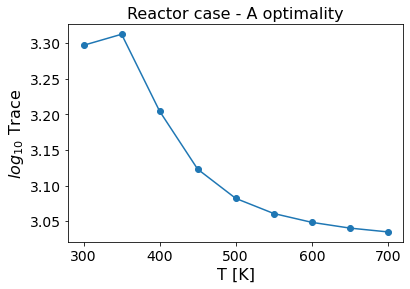

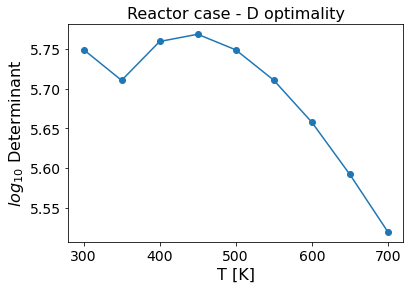

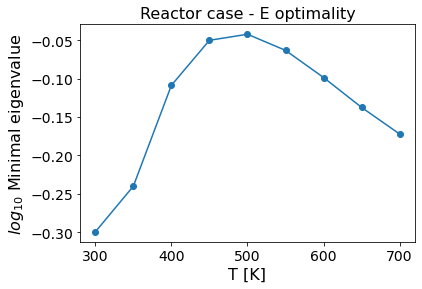

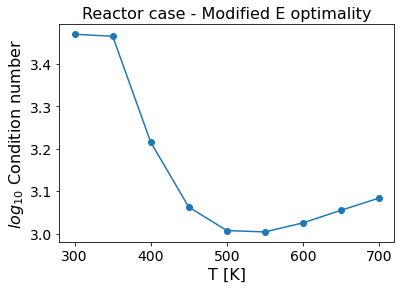

In [21]:
test = all_fim.extract_criteria()

## draw 1D sensitivity curve 

fixed = {"'CA0'": 5.0}

all_fim.figure_drawing(fixed, ['T'], 'Reactor case','T [K]','$C_{A0}$ [M]' )



## Heatmap

2D heatmap is plotted with  ['CA0', 'T'] .


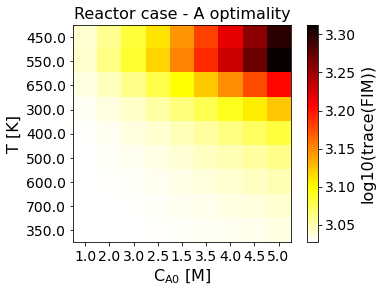

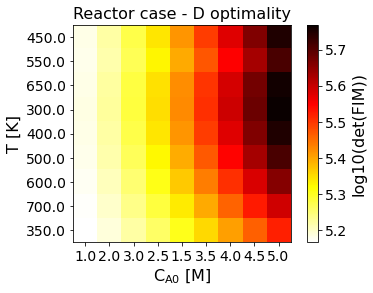

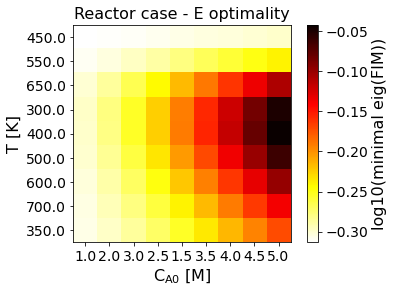

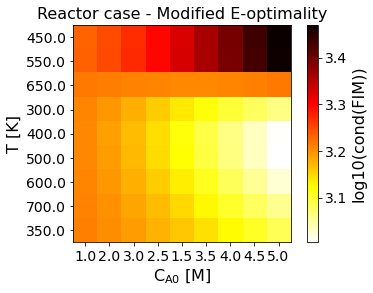

In [22]:
fixed = {}
all_fim.figure_drawing(fixed, ['CA0','T'], 'Reactor case','$C_{A0}$ [M]', 'T [K]' )

## Grid search for 3 design variables

In [ ]:

design_ranges = [list(np.linspace(1,5,2)),  list(np.linspace(300,700,2)), [300,500]]

dv_apply_name = ['CA0', 'T', 'T']
dv_apply_time = [[0], [0], [0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875,1]]

# Define experiments
if (model_opt=='dynamic-DAE'):
    exp1 = generate_exp(t_control, 5, [570.21, 300, 300, 300, 300, 300, 300, 300, 300])
else: 
    exp1 = generate_exp(t_control, 5, [500])

In [ ]:
doe_object = DesignOfExperiments(parameter_dict, dv_pass, 
                                 ['CA','CB','CC'], t_measure, createmod,
                                 prior_FIM=prior_pass, discretize_model=disc)

all_fim = doe_object.run_grid_search(exp1, design_ranges,dv_apply_name, dv_apply_time, 
                                     mode='sequential_finite', 
                                    scale_nominal_param_value=True
                                    )

### Draw 1D sensitivity curve

In [ ]:
test = all_fim.extract_criteria()

In [ ]:
## draw 1D sensitivity curve 

fixed = {"'CA0'": 1.0, "'T2'": 300}

all_fim.figure_drawing(fixed, ['T'], 'Reactor case','T [K]','$C_{A0}$ [M]' )

### Draw 2D sensitivity curve

In [ ]:
fixed = {"'T2'": 300}

all_fim.figure_drawing(fixed, ['CA0','T'], 'Reactor case','$C_{A0}$ [M]', 'T [K]' )